# `rustc` CGU size estimation analysis
I have enjoyed following [@nnethercote](https://nnethercote.github.io/)'s series ([[1]](https://nnethercote.github.io/2023/08/01/how-to-speed-up-the-rust-compiler-data-analysis-update.html), [[2]](https://nnethercote.github.io/2023/07/25/how-to-speed-up-the-rust-compiler-data-analysis-assistance-requested.html), [[3]](https://nnethercote.github.io/2023/07/11/back-end-parallelism-in-the-rust-compiler.html)) of blog posts on estimating the "size" of CGUs. The motivation is that a better estimate will more accurately guide the ordering of CGU processing in `rustc`'s parallel backend, thus cutting down on compilation times. One of the desiderata in [2] was that any new estimate be "comprehensible" and not "too complex". I have attempted an analysis of this problem in this notebook, using the data provided in [3]. To summarize the results:

* Keeping the current estimate but switching the CGU processing order for opt builds from "interleave" to "high-low" (see below) made simulated (pre-LTO) opt build times about 0.6% faster. On the other hand, switching the CGU processing order for debug builds from "interleave" to "high-low" made simulated debug build times about 2% *slower*.
* By switching the CGU processing order to "high-low" and using a hypothetical "optimal" estimate (where the true $t_{opt}$ values are used as their own estimate), the greatest hypothetical speedup in simulated build times compared to using the current estimate and "interleave" ordering is about 4%, for both (pre-LTO) opt and debug builds.
* I was not able to find a "simple" estimate (linear combination of 5 or so features) that improved simulated (pre-LTO) opt or debug build times compared to the current estimate, when using the current "interleave" CGU processing order for both.
* When comparing a new estimate using "high-low" ordering with the current estimate using "interleave" ordering, the best performing "simple" estimate I found for (pre-LTO) opt builds resulted in a simulated speedup of about 0.7%. For debug builds, the best performing "simple" estimate I found resulted in a negligible simulated speedup of about 0.1%.
* Decidedly complex and incomprehensible estimates (huge gradient boosted trees models), combined with switching to "high-low" ordering, resulted in simulated speedups of about 1-2% for (pre-LTO) opt build times, and about 0-1% for debug build times (not accounting for the time it would take to compute these estimates).

It turns out that the problem is, not surprisingly, a difficult one. Somewhat counterintuitively, models that most accurately estimate $t_{opt}$ (the time for LLVM to process the LLVM IR; the times that form the "waterfall" parallel structure shown in [1]) turn out not to give the best results, since underestimation of a single CGU can significantly increase the overall compilation time. I had the most success with quantile regression, which allows one to estimate a higher quantile of the $t_{opt}$ distribution given the predictive features, thus forming a sort of pessimistic, "worse-case" estimate for each CGU. This allows one to hedge against particularly egregious underestimations. 

To measure the performance of an arbitrary estimate, I simulated the (pre-LTO) compile times of each crate in the data set by calculating $\max_i \sum_{j=1}^i {t_{gen}}_j + {t_{opt}}_i$, where $i \in \{1,\dotsc,n\}$ is the $i$-th ordered CGU according to the estimate and ordering method.

This brings in another problem: the method by which one orders the CGU processing in light of one's estimate can significantly affect the results. In [1], the discussion focuses on the case of ordering the CGUs in a "high-low" fashion, where the CGUs are processed in order from largest to smallest according to one's estimate. However, as mentioned in that blog post, apparently `rustc` does not do this, but instead uses an "interleave" method, where the largest CGU is processed first, then the smallest, then the second-largest, then the second-smallest, and so on. It turns out that a new estimate that reduces simulated compile times compared to the current estimate when the "high-low" ordering method is used with both might very well lead to worse compile times than the current estimate when the "interleave" ordering method is used with both, or even when "high-low" ordering is used with the new estimate and "interleave" ordering is used with the current estimate. 

The variation in results with the different ordering methods led me to wonder: what is the optimal ordering algorithm? Say one knows in advance ${t_{gen}}_i$ and ${t_{opt}}_i$ for each CGU $i$. What is the optimal ordering of the CGUs to minimize the total compile time? After some digging, I found that this is a version of what is known as the hybrid flow shop scheduling problem; in particular, it is a two-stage hybrid flow shop with parallel machines at the second stage. It turns out that "high-low" ordering based on $t_{opt}$ is indeed optimal for this problem, as shown in [Gupta & Tunc (1991)](https://doi.org/10.1080/00207549108948025) (as long as the number of CGUs does not exceed the number of machine cores).

So why should it ever happen, as it does for simulated debug builds in this analysis, that a new estimate that improves simulated compile times compared to the current estimate when both use the theoretically optimal "high-low" ordering, ends up being worse than the current estimate when the new estimate uses the theoretically optimal "high-low" ordering and the current estimate uses the theoretically sub-optimal "interleave" ordering? Shouldn't the new estimate perform even better in this case? I can't say I know the answer. 

Surely it has to do with the fact that the theoretical optimality of "high-low" ordering doesn't exactly apply here, since in the theoretical case ${t_{opt}}_i$ are known. In the present case, they are doubly uncertain: for the same crate, ${t_{opt}}_i$ varies between runs; and for two different crates, even if they happen to share the same number of CGUs and the exact same predictive feature values (`rproj`, `rssd_`, etc.) for each, they will result in different ${t_{opt}}_i$ values due to their different structures.

Another consideration is that quantile regression with a high quantile tends to handle much better the cases where with the current estimate a "long pole" underestimated CGU causes a slower compile time, but on the other hand, it tends to overestimate the size of small and medium CGUs such that the ability to distinguish among them is reduced. I suppose that the combination of these factors somehow conspires to make it so that the current estimate and ordering method are somehow competitive with or even better than what should intuitively be a better estimate and ordering method. It's interesting enough that I would almost like to look into it further, but I've now spent too much time on this :). 

For what it's worth, the best "simple" models I found are, for opt:

```rust
0.0125364935802607 * rfn__ +
0.415786186871462 * ifn__ +
0.137799175804506 * rbb__ +
0.0144926571726526 * ibb__ +
0.0241331729868041 * issd_ +
0.107125611181126 * rproj +
548.458894692552
```

and for debug:

```rust
0.048239676702817 * rfn__ +
0.0245365801571638 * rbb__ +
0.0757966403768962 * ibb__ +
0.0021922720265935 * rplac +
0.000367269165252557 * rproj +
0.0100128515730395 * rdecl +
24.9201931013653
```

The huge gradient boosted trees models are included, for amusement, as separate files in this repo: `opt_maximalist_gbt.rs` and `debug_maximalist_gbt.rs`.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import r_regression
from lightgbm import LGBMRegressor
from glob import glob
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
from toolz.itertoolz import interleave
from skompiler import skompile
import m2cgen as m2c

In [2]:
features = [ 
    'rfn__', 'ifn__', 'rbb__', 'ibb__', 'rssd_', 'issd_', 'rstmt', 'istmt',
    'rplac', 'iplac', 'rproj', 'iproj', 'rcnst', 'icnst', 'rdecl', 'idecl',
    'sttic',
    'cgu_tot',
]

target = 't_opt__'

def read_data_file(filename):
    data = pd.read_csv(filename, comment='#', sep='\s+')
    kind, run = re.search(r'(\w+)-Top1000-(\d+).txt', filename).groups()
    data['kind'] = kind.lower()
    data['run'] = int(run)
    cgu_pattern = r'CGU-([^.]+)\.([^-]+)-cgu\.(\d+)'
    data[['cgu_crate', 'cgu_hash', 'cgu_num']] = data['cgu_name'].str.extract(cgu_pattern)
    data['cgu_num'] = data['cgu_num'].astype(int)
    return data

def read_data(kind=None):
    data = pd.concat([read_data_file(f) for f in glob('data/*.txt')])
    if kind:
        data = data[data['kind'] == kind]
    data.sort_values(['cgu_hash', 'run'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    cgu_tot = data.groupby(['cgu_hash', 'run']).size()
    data['cgu_tot'] = data.apply(lambda x: cgu_tot[(x['cgu_hash'], x['run'])], axis=1)

    test_frac = 0.1
    last_train_hash_idx = int((1 - test_frac) * len(data))
    last_train_hash = data.iloc[last_train_hash_idx]['cgu_hash']
    train_idx = data['cgu_hash'] <= last_train_hash
    train = data[train_idx].copy()
    test_idx = data['cgu_hash'] > last_train_hash
    test = data[test_idx].copy()

    return data, train, test

In [3]:
kind = 'opt'
data, train, test = read_data(kind)

In [4]:
def time_high_low(d, est):
    def inner(x):
        high_low = x.sort_values(est, ascending=False)
        return (high_low['t_gen__'].cumsum() + high_low['t_opt__']).max()
    return d.groupby(['cgu_hash', 'run']).apply(inner)

def time_interleave(d, est):
    def inner(x):
        high_low = x.sort_values(est, ascending=False)
        low_high = x.sort_values(est, ascending=True)
        interleaved = pd.DataFrame(interleave([high_low.values, low_high.values]), columns=data.columns).iloc[:len(x)]
        return (interleaved['t_gen__'].cumsum() + interleaved['t_opt__']).max()
    return d.groupby(['cgu_hash', 'run']).apply(inner)

def rel_diff_ordering(d, est):
    t_high_low = time_high_low(d, est)
    t_interleave = time_interleave(d, est)
    return ((t_high_low - t_interleave) / t_interleave).mean()

def total_rel_diff_ordering(d, est):
    t_high_low = time_high_low(d, est).sum()
    t_interleave = time_interleave(d, est).sum()
    return (t_high_low - t_interleave) / t_interleave

def rel_diff(d, est1, est2, time_fn1, time_fn2):
    est1_t = time_fn1(d, est1)
    est2_t = time_fn2(d, est2)
    return ((est2_t - est1_t) / est1_t).mean()

def total_rel_diff(d, est1, est2, time_fn1, time_fn2):
    est1_t = time_fn1(d, est1).sum()
    est2_t = time_fn2(d, est2).sum()
    return (est2_t - est1_t) / est1_t

def time_comparison(est1, est1_name, est2, est2_name):
    print(f'\naverage relative difference in time taken using high-low ordering with {est2_name} vs. {est1_name} estimate:')
    for dn, d in zip(['train', 'test', 'all'], [train, test, data]):
        print('  {}: {:5f}'.format(dn, rel_diff(d, est1, est2, time_high_low, time_high_low)))
    print(f'\naverage relative difference in time taken using interleave ordering with {est2_name} vs. {est1_name} estimate:')
    for dn, d in zip(['train', 'test', 'all'], [train, test, data]):
        print('  {}: {:5f}'.format(dn, rel_diff(d, est1, est2, time_interleave, time_interleave)))
    print(f'\naverage relative difference in time taken using high-low ordering with {est2_name} estimate vs. interleave ordering with {est1_name} estimate:')
    for dn, d in zip(['train', 'test', 'all'], [train, test, data]):
        print('  {}: {:5f}'.format(dn, rel_diff(d, est1, est2, time_interleave, time_high_low)))
    print(f'\nrelative difference in total time taken using high-low ordering with {est2_name} vs. {est1_name} estimate:')
    for dn, d in zip(['train', 'test', 'all'], [train, test, data]):
        print('  {}: {:5f}'.format(dn, total_rel_diff(d, est1, est2, time_high_low, time_high_low)))
    print(f'\nrelative difference in total time taken using interleave ordering with {est2_name} vs. {est1_name} estimate:')
    for dn, d in zip(['train', 'test', 'all'], [train, test, data]):
        print('  {}: {:5f}'.format(dn, total_rel_diff(d, est1, est2, time_interleave, time_interleave)))
    print(f'\nrelative difference in total time taken using high-low ordering with {est2_name} estimate vs. interleave ordering with {est1_name} estimate:')
    for dn, d in zip(['train', 'test', 'all'], [train, test, data]):
        print('  {}: {:5f}'.format(dn, total_rel_diff(d, est1, est2, time_interleave, time_high_low)))

    fig, axs = plt.subplots(3, 3, figsize=(12, 6))
    for i, (dn, d) in enumerate(zip(['train', 'test', 'all'], [train, test, data])):
        for j, ((t_fn1, t_fn2), ord_name) in enumerate(zip((
            (time_high_low, time_high_low), (time_interleave, time_interleave), (time_interleave, time_high_low)), 
            ('high-low', 'interleave', 'high-low vs. interleave'))):
            ax = axs[i, j]
            est1_t = t_fn1(d, est1)
            t = t_fn2(d, est2) - est1_t
            t = t[t != 0]
            step = 5
            tmin = 0 if np.isnan(t.min()) else t.min()
            tmax = 0 if np.isnan(t.max()) else t.max()
            steps = np.arange(step * (tmin // step) - step, step * (tmax // step) + 2 * step, step)
            sns.histplot(t, bins=steps, ax=ax)
            sns.rugplot(t, ax=ax, color='black')
            ax.set_title(f'{dn} data {ord_name} ordering')
            ax.set_xlabel(f'{est2_name} - {est1_name} estimate time')
    fig.suptitle(f'non-zero differences in time taken, {est2_name} vs. {est1_name} estimate')
    plt.tight_layout()

In [5]:
def ordering_time_comparison():
    print('average relative difference in time taken using current estimate high-low ordering vs. current estimate interleave ordering:')
    print('  all: {:5f}'.format(rel_diff_ordering(data, 'est__')))

    print('\naverage relative difference in time taken using "optimal" high-low ordering vs. "optimal" interleave ordering:')
    print('  all: {:5f}'.format(rel_diff_ordering(data, 't_opt__')))

    print('\nrelative difference in total time taken using current estimate high-low ordering vs. current estimate interleave ordering:')
    print('  all: {:5f}'.format(total_rel_diff_ordering(data, 'est__')))

    print('\nrelative difference in total time taken using "optimal" high-low ordering vs. "optimal" interleave ordering:')
    print('  all: {:5f}'.format(total_rel_diff_ordering(data, 't_opt__')))

In [6]:
ordering_time_comparison()

average relative difference in time taken using current estimate high-low ordering vs. current estimate interleave ordering:
  all: -0.006365

average relative difference in time taken using "optimal" high-low ordering vs. "optimal" interleave ordering:
  all: -0.008011

relative difference in total time taken using current estimate high-low ordering vs. current estimate interleave ordering:
  all: -0.006476

relative difference in total time taken using "optimal" high-low ordering vs. "optimal" interleave ordering:
  all: -0.009817



average relative difference in time taken using high-low ordering with "optimal" vs. current estimate:
  train: -0.022841
  test: -0.018434
  all: -0.022342

average relative difference in time taken using interleave ordering with "optimal" vs. current estimate:
  train: -0.021262
  test: -0.018262
  all: -0.020922

average relative difference in time taken using high-low ordering with "optimal" estimate vs. interleave ordering with current estimate:
  train: -0.029034
  test: -0.022459
  all: -0.028290

relative difference in total time taken using high-low ordering with "optimal" vs. current estimate:
  train: -0.033821
  test: -0.021577
  all: -0.033161

relative difference in total time taken using interleave ordering with "optimal" vs. current estimate:
  train: -0.030181
  test: -0.024952
  all: -0.029899

relative difference in total time taken using high-low ordering with "optimal" estimate vs. interleave ordering with current estimate:
  train: -0.040060
  test: -0.028244
  a

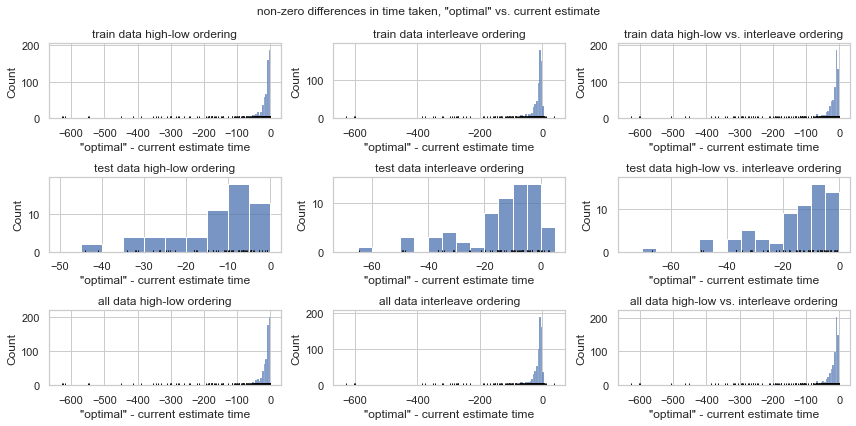

In [7]:
time_comparison('est__', 'current', 't_opt__', '"optimal"')

In [8]:
def feature_correlations():
    r = pd.DataFrame({"feature": features, "r": r_regression(data[features], data['t_opt__'])})
    r = r.sort_values(by=['r'], ascending=False)
    print(r.to_string(index=False))

In [9]:
feature_correlations()

feature        r
  ibb__ 0.753324
  ifn__ 0.753142
  issd_ 0.746776
  idecl 0.721199
  iplac 0.719544
  rbb__ 0.709613
  iproj 0.708754
  rproj 0.701409
  rdecl 0.668884
  icnst 0.661733
  rplac 0.652357
  rcnst 0.643814
  rstmt 0.603720
  rfn__ 0.602833
  rssd_ 0.484112
  istmt 0.329395
cgu_tot 0.281251
  sttic 0.040602


In [10]:
def lin_reg_fit(alpha, quantile, est_name='lin_reg_est', compare_times=True):
    scale = StandardScaler()

    model = QuantileRegressor(
        quantile=quantile,
        alpha=alpha,
        fit_intercept=True,
        solver='highs',
    )

    pipe = Pipeline(steps=[('scale', scale), ('model', model)])
    pipe.fit(train[features], train[target])

    data[est_name] = pipe.predict(data[features])
    train[est_name] = pipe.predict(train[features])
    test[est_name] = pipe.predict(test[features])

    print(lin_reg_text(pipe, est_name))

    if compare_times:
        time_comparison('est__', 'current', est_name, 'new')

def lin_reg_text(pipe, est_name='lin_reg_est'):
    formula = skompile(pipe, 'predict').to('sympy/rust')
    # remove initial 'y = ' and final ';' from the formula
    formula = formula[4:-1]

    pattern = re.compile(r'x\[(\d+)\]')
    
    # sanity check that the skompile formula prediction matches the pipeline prediction
    replace_x = lambda m: 'data["{0}"]'.format(features[int(m.group(1))])
    df_formula = pattern.sub(replace_x, formula)
    df_y = eval(df_formula)
    formula_prediction = df_y.values
    assert(np.allclose(formula_prediction, data[est_name].values))

    # basic text version of formula
    replace_x = lambda m: features[int(m.group(1))]
    text = pattern.sub(replace_x, formula)
    text = text.replace(' + ', ' +\n').replace('*', ' * ')
    return text

0.0125364935802607 * rfn__ +
0.415786186871462 * ifn__ +
0.137799175804506 * rbb__ +
0.0144926571726526 * ibb__ +
0.0241331729868041 * issd_ +
0.107125611181126 * rproj +
548.458894692552

average relative difference in time taken using high-low ordering with new vs. current estimate:
  train: 0.002720
  test: 0.001471
  all: 0.002579

average relative difference in time taken using interleave ordering with new vs. current estimate:
  train: 0.002078
  test: -0.000812
  all: 0.001751

average relative difference in time taken using high-low ordering with new estimate vs. interleave ordering with current estimate:
  train: -0.004184
  test: -0.002864
  all: -0.004034

relative difference in total time taken using high-low ordering with new vs. current estimate:
  train: -0.001206
  test: 0.000312
  all: -0.001125

relative difference in total time taken using interleave ordering with new vs. current estimate:
  train: 0.001119
  test: -0.003573
  all: 0.000866

relative difference in to

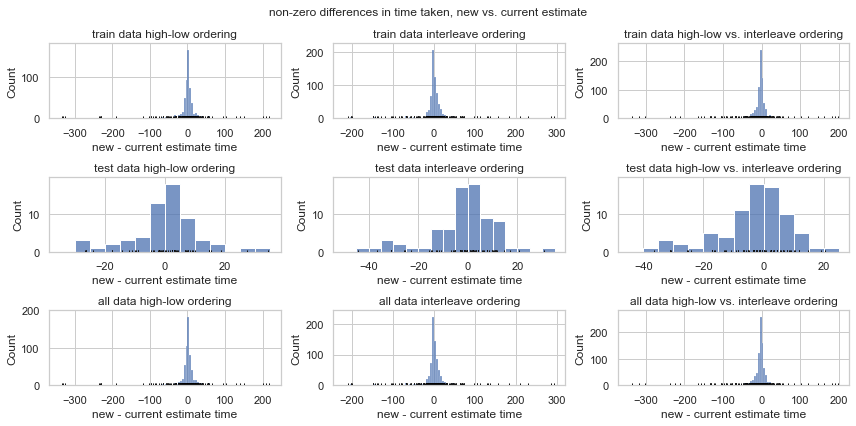

In [11]:
lin_reg_fit(alpha=0.02, quantile=0.99)

In [12]:
def gbt_fit(gbt, style):
    gbt.fit(train[features], train[target], eval_set=[(test[features], test[target])])

    print('\n{}'.format(pd.DataFrame({'feature': gbt.feature_name_, 'importance': gbt.feature_importances_}).sort_values('importance', ascending=False).to_string(index=False)))

    data[f'{style}_gbt_est'] = gbt.predict(data[features])
    train[f'{style}_gbt_est'] = gbt.predict(train[features])
    test[f'{style}_gbt_est'] = gbt.predict(test[features])

    with open(f'{kind}_{style}_gbt.rs', 'w') as out:
        out.write(gbt_text(gbt))

    time_comparison('est__', 'current', f'{style}_gbt_est', 'new')

def gbt_text(gbt):
    text = m2c.export_to_rust(gbt)
    n1 = text.find('\n')
    text = 'fn score() -> f64 {\n' + text[n1+1:]
    pattern = re.compile(r'input\[(\d+)\]')
    replace_x = lambda m: features[int(m.group(1))]
    text = pattern.sub(replace_x, text)
    return text


feature  importance
  rproj        1791
  rfn__        1696
  rssd_        1696
  rcnst        1544
  rbb__        1504
  iproj        1355
  icnst        1344
  issd_        1317
  ifn__        1302
  rstmt        1193
  istmt        1124
  ibb__        1104
  rdecl         921
  rplac         757
  iplac         735
cgu_tot         649
  idecl         648
  sttic          44

average relative difference in time taken using high-low ordering with new vs. current estimate:
  train: -0.008515
  test: -0.005450
  all: -0.008168

average relative difference in time taken using interleave ordering with new vs. current estimate:
  train: -0.004404
  test: -0.001348
  all: -0.004058

average relative difference in time taken using high-low ordering with new estimate vs. interleave ordering with current estimate:
  train: -0.015115
  test: -0.009620
  all: -0.014493

relative difference in total time taken using high-low ordering with new vs. current estimate:
  train: -0.014936
  test: -0.0

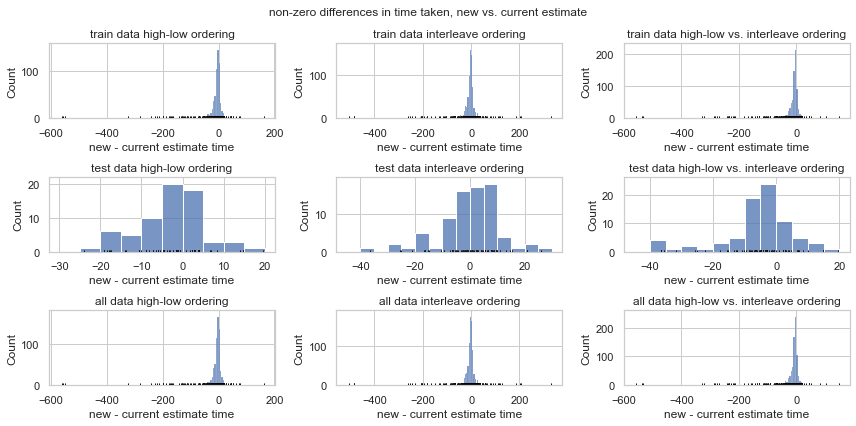

In [13]:
gbt = LGBMRegressor(metric='quantile', objective='quantile', alpha=0.95, n_estimators=300, num_leaves=255, min_child_samples=150, reg_alpha=1, reg_lambda=1, verbose=-1)
gbt_fit(gbt, 'maximalist')

In [14]:
kind = 'debug'
data, train, test = read_data(kind)

In [15]:
ordering_time_comparison()

average relative difference in time taken using current estimate high-low ordering vs. current estimate interleave ordering:
  all: 0.017031

average relative difference in time taken using "optimal" high-low ordering vs. "optimal" interleave ordering:
  all: -0.039539

relative difference in total time taken using current estimate high-low ordering vs. current estimate interleave ordering:
  all: 0.021071

relative difference in total time taken using "optimal" high-low ordering vs. "optimal" interleave ordering:
  all: -0.050775



average relative difference in time taken using high-low ordering with "optimal" vs. current estimate:
  train: -0.042905
  test: -0.042106
  all: -0.042824

average relative difference in time taken using interleave ordering with "optimal" vs. current estimate:
  train: 0.012975
  test: 0.008955
  all: 0.012564

average relative difference in time taken using high-low ordering with "optimal" estimate vs. interleave ordering with current estimate:
  train: -0.028469
  test: -0.029773
  all: -0.028602

relative difference in total time taken using high-low ordering with "optimal" vs. current estimate:
  train: -0.058538
  test: -0.067352
  all: -0.059337

relative difference in total time taken using interleave ordering with "optimal" vs. current estimate:
  train: 0.012408
  test: 0.006348
  all: 0.011861

relative difference in total time taken using high-low ordering with "optimal" estimate vs. interleave ordering with current estimate:
  train: -0.039113
  test: -0.043586
  all: -0

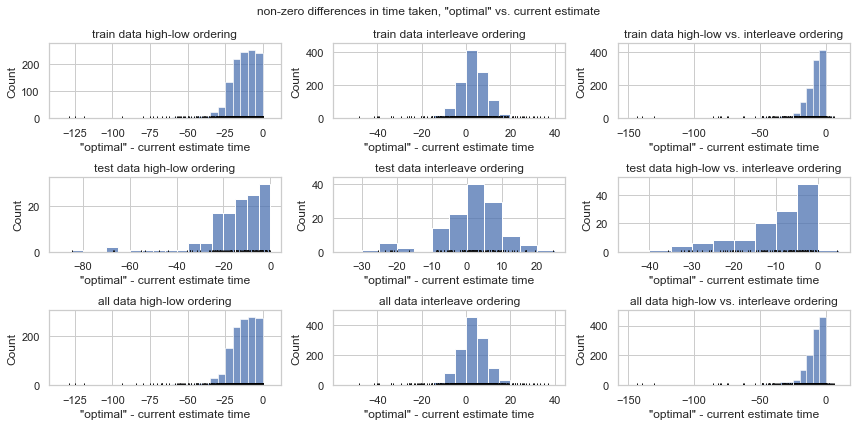

In [16]:
time_comparison('est__', 'current', 't_opt__', '"optimal"')

In [17]:
feature_correlations()

feature        r
  rbb__ 0.919836
  rdecl 0.912345
  rplac 0.895744
  rcnst 0.865994
  rproj 0.808037
  rfn__ 0.790571
  rstmt 0.775385
  rssd_ 0.685485
  ifn__ 0.465782
  issd_ 0.432970
  ibb__ 0.399690
  istmt 0.394789
  idecl 0.394382
  iplac 0.371901
  iproj 0.343552
  icnst 0.319838
cgu_tot 0.267751
  sttic 0.047304


0.048239676702817 * rfn__ +
0.0245365801571638 * rbb__ +
0.0757966403768962 * ibb__ +
0.0021922720265935 * rplac +
0.000367269165252557 * rproj +
0.0100128515730395 * rdecl +
24.9201931013653

average relative difference in time taken using high-low ordering with new vs. current estimate:
  train: -0.010941
  test: -0.011702
  all: -0.011018

average relative difference in time taken using interleave ordering with new vs. current estimate:
  train: 0.014798
  test: 0.017709
  all: 0.015096

average relative difference in time taken using high-low ordering with new estimate vs. interleave ordering with current estimate:
  train: 0.005309
  test: 0.002503
  all: 0.005022

relative difference in total time taken using high-low ordering with new vs. current estimate:
  train: -0.021136
  test: -0.028685
  all: -0.021820

relative difference in total time taken using interleave ordering with new vs. current estimate:
  train: 0.015821
  test: 0.020568
  all: 0.016250

relative difference in

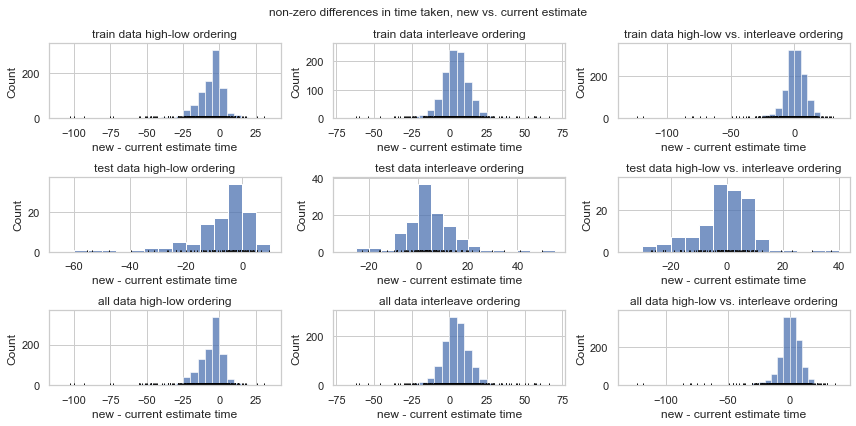

In [18]:
lin_reg_fit(alpha=0.05, quantile=0.95)


feature  importance
  rfn__        1969
  rssd_        1760
  rproj        1668
  rbb__        1617
  rcnst        1552
  rstmt        1534
  rdecl        1201
  rplac        1006
  istmt         518
cgu_tot         496
  iplac         468
  ibb__         415
  ifn__         398
  iproj         387
  issd_         369
  icnst         337
  idecl         322
  sttic          57

average relative difference in time taken using high-low ordering with new vs. current estimate:
  train: -0.021671
  test: -0.011605
  all: -0.020642

average relative difference in time taken using interleave ordering with new vs. current estimate:
  train: 0.013940
  test: 0.010859
  all: 0.013625

average relative difference in time taken using high-low ordering with new estimate vs. interleave ordering with current estimate:
  train: -0.006188
  test: 0.002488
  all: -0.005302

relative difference in total time taken using high-low ordering with new vs. current estimate:
  train: -0.035094
  test: -0.02457

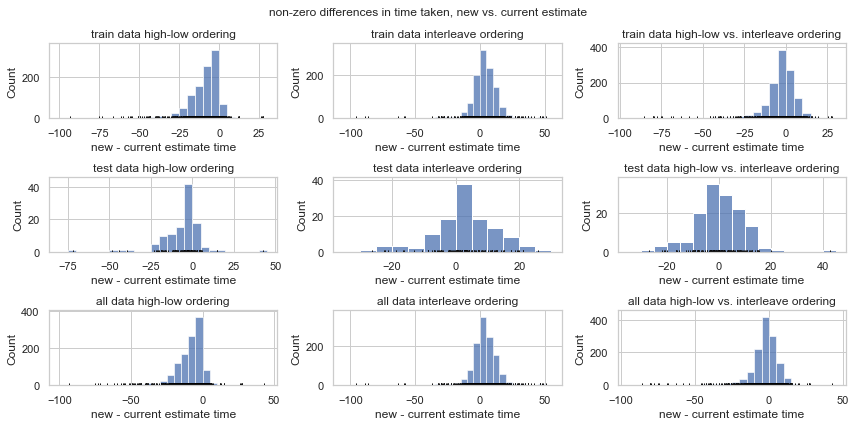

In [19]:
gbt = LGBMRegressor(metric='quantile', objective='quantile', alpha=0.75, n_estimators=300, num_leaves=255, min_child_samples=150, reg_alpha=10, reg_lambda=10, verbose=-1)
gbt_fit(gbt, 'maximalist')